In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
!wget -O wind_farm.csv https://www.dropbox.com/s/0hyfdcnuoy0qw85/REsurety_GIS_Developer.csv?dl=1

--2019-08-02 13:46:35--  https://www.dropbox.com/s/0hyfdcnuoy0qw85/REsurety_GIS_Developer.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/0hyfdcnuoy0qw85/REsurety_GIS_Developer.csv [following]
--2019-08-02 13:46:35--  https://www.dropbox.com/s/dl/0hyfdcnuoy0qw85/REsurety_GIS_Developer.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8d8e9fdfa2d1eedf0f3ff64d7f.dl.dropboxusercontent.com/cd/0/get/Al1QmEeMURfn9yjL0yKXoT-S_XB80-_5p0grW1DUUv-bDakzpFGVbA-_r4vQtX3g0OwTjTkqJcN3vqbFQ--IO2FhZeIvEk8Me87SKkJuGKR8IQ/file?dl=1# [following]
--2019-08-02 13:46:35--  https://uc8d8e9fdfa2d1eedf0f3ff64d7f.dl.dropboxusercontent.com/cd/0/get/Al1QmEeMURfn9yjL0yKXoT-S_XB80-_5p0grW1DUUv-bDakzpFGVbA-_r4vQtX3g0OwTjTkqJcN3vqbFQ--IO2FhZeI

In [86]:
wind_farm_df = pd.read_csv('wind_farm.csv')
wind_farm_df.drop(['Unnamed: 0'],axis=1,inplace=True)

(array([30.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([0.   , 0.095, 0.19 , 0.285, 0.38 , 0.475, 0.57 , 0.665, 0.76 ,
        0.855, 0.95 ]),
 <a list of 10 Patch objects>)

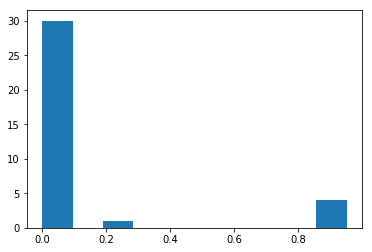

In [87]:
# look at the distribution of wind farms that are smaller than 1 MW
plt.hist(wind_farm_df[wind_farm_df['CapacityMW'] < 1]['CapacityMW'],bins=10)

In [88]:
# plants with capacity lower than 200 kW is filtered out as research scale plants
prof_wind_farm = wind_farm_df[wind_farm_df['CapacityMW'] > 0.2].copy()

In [89]:
# drop plants with NaN generation data and then reset the index 
prof_wind_farm.dropna(inplace=True)
prof_wind_farm.reset_index(drop=True, inplace=True)

In [90]:
# convert the latitude and longitude to radians for convenience of distance calculation  
prof_wind_farm['Latitude_r']=prof_wind_farm['Latitude'].apply(lambda x: math.radians(x))
prof_wind_farm['Longitude_r']=prof_wind_farm['Longitude'].apply(lambda x: math.radians(x))

In [91]:
# calculate the net capacity factor for efficiency evaluation
prof_wind_farm['net capacity factor'] = prof_wind_farm['GenerationMWhPerYear']/(prof_wind_farm['CapacityMW'] * 8760)

In [92]:
prof_wind_farm.head()

,ID,Name,Latitude,Longitude,CapacityMW,GenerationMWhPerYear,Latitude_r,Longitude_r,net capacity factor
0,1,Lamar Plant,37.864950,-102.561775,6.00,10100.739233,0.660868,-1.790041,0.192175
1,3,Geneseo,41.451494,-90.148547,3.00,6431.014021,0.723465,-1.573389,0.244711
2,4,Osage,43.292500,-92.840600,1.50,4788.684212,0.755597,-1.620374,0.364436
3,5,Mountain Lake,43.940500,-94.943400,1.25,3508.997897,0.766906,-1.657075,0.320456
4,6,Willmar,45.158000,-95.007450,4.00,6569.591150,0.788156,-1.658193,0.187488


In [93]:
# find the distance between location pairs and record the indices and the net capacity factors of a pair of points if the distance between them is 
# shorter than 100 km

list=[]

for i in range(1,prof_wind_farm.shape[0]):
    lat1 = prof_wind_farm.iloc[i,6]
    lon1 = prof_wind_farm.iloc[i,7]
    for n, lat2, lon2 in zip(prof_wind_farm.index.values[:i], prof_wind_farm.iloc[:i,6],prof_wind_farm.iloc[:i,7]):
        dist = math.acos(round(math.sin(lat1) * math.sin(lat2) + math.cos(lat1) * math.cos(lat2) * math.cos(lon1-lon2),10))*6371
        if dist < 100:
            list.append([i, prof_wind_farm.iloc[i,8], n, prof_wind_farm.iloc[n,8]])

In [94]:
# revert the list and then merge it with the orginial list to make sure all the location indices are captured in the 'index ' column

raw_list1 = pd.DataFrame(list,columns=['index','eff','n_index','n_eff'])
columns = raw_list1.columns.tolist()
columns = columns[-2:] + columns[:2]
raw_list2 = raw_list1[columns]
raw_list2.columns = ['index','eff','n_index','n_eff']
final_list=pd.concat([raw_list1,raw_list2],axis=0,sort=False)

In [95]:
# the way I use to identify inefficient farms is to compare its net capacity factor with its surround locations, but because at some locations,
# the net capacity values of points are very close to each other, it is unfair to categorize a point as inefficient when its value is only slightly
# lower than the average, so I created a ranking of inefficiency: if a point's value is less 20% below the average, it's labeled -1; if it is 20-40% 
# below the average, it is labeled -2;  while if it is above 40% lower than the regional average, it is label -3. Hopefully this way investors can 
# get a better understanding of the scale of risk 

if the net capacity factor of one point is less than 20% below average, it is label -1

low_eff_list = []
for group, frame in final_list.groupby('index'):
    avg_val = frame['n_eff'].mean()
    eff = frame['eff'].mean()
    if avg_val > eff and eff > 0.8*avg_val:
        low_eff_list.append([-1,group])
    elif 0.8*avg_val > eff and eff > 0.6*avg_val:
        low_eff_list.append([-2,group])
    elif 0.6*avg_val > eff:
        low_eff_list.append([-3,group])


In [96]:
prof_wind_farm.reset_index(inplace = True)

In [97]:
prof_wind_farm.head()

,index,ID,Name,Latitude,Longitude,CapacityMW,GenerationMWhPerYear,Latitude_r,Longitude_r,net capacity factor
0,0,1,Lamar Plant,37.864950,-102.561775,6.00,10100.739233,0.660868,-1.790041,0.192175
1,1,3,Geneseo,41.451494,-90.148547,3.00,6431.014021,0.723465,-1.573389,0.244711
2,2,4,Osage,43.292500,-92.840600,1.50,4788.684212,0.755597,-1.620374,0.364436
3,3,5,Mountain Lake,43.940500,-94.943400,1.25,3508.997897,0.766906,-1.657075,0.320456
4,4,6,Willmar,45.158000,-95.007450,4.00,6569.591150,0.788156,-1.658193,0.187488


In [84]:

low_eff_df = pd.DataFrame(low_eff_list, columns=['efficiency label','index'])

In [103]:
prof_wind_farm = prof_wind_farm.merge(low_eff_df, on='index',how='left').fillna(0)

In [106]:
from IPython.display import HTML
import base64

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(prof_wind_farm)

link to ArcGIS online web application: https://mit.maps.arcgis.com/apps/InteractiveLegend/index.html?appid=9ba602d4b4cb446291191e6a07d7808e